### APHRC Project - Data Protection Act Question Answering LLM Implementation

#### This project focuses on Data Protection Acts of Kenya, Uganda and Rwanda.

#### Q&A Architecture

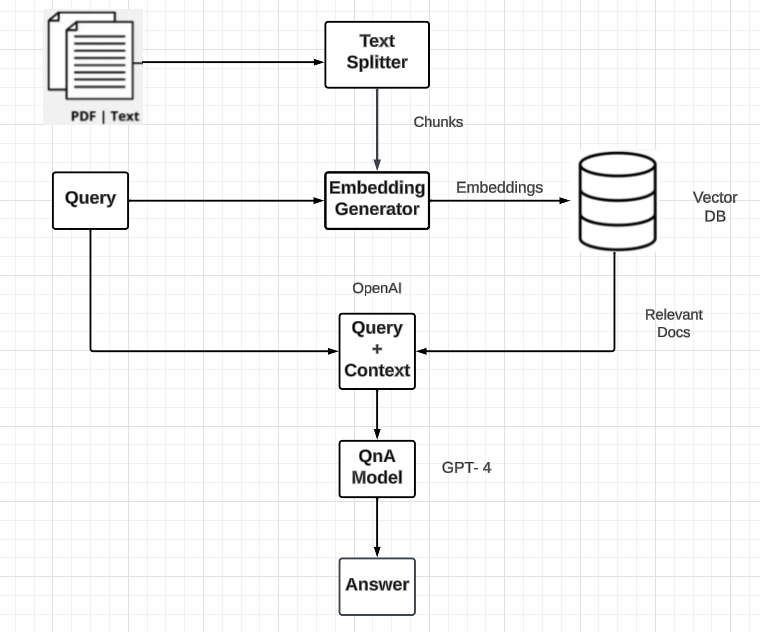

#### Installing required module

In [1]:
# Importing the modules.
import os 
import openai
from langchain.llms import OpenAI
from langchain.vectorstores import Chroma
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import ConversationalRetrievalChain
from langchain.chains.question_answering import load_qa_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [2]:
# Defining the Model name and getting the API_KEY.
os.environ['LANGCHAIN_OPENAI_MODEL'] = 'GPT-3.5 Turbo' 
os.environ["OPENAI_API_KEY"] = "sk-"


#### Preparing the documents

In [3]:
# Loading documents
pdf_folder_path = './docs/'
os.listdir(pdf_folder_path)

['ComputerMisuseandCybercrimesActNo5of2018.pdf',
 'Data Protection Laws Content.pdf',
 'Data-Protection-Act-Kenya.pdf',
 'Data-Protection-Act-Rwanda.pdf',
 'Data-Protection-Act-Uganda.pdf',
 'HUDUMA NAMBA REGULATIONS- 2020.2021.pdf',
 'ODPC-Complaints-Management-Manual.pdf',
 'ODPC-Guidance-Note-for-Digital-Credit-Providers.pdf',
 'ODPC-Guidance-Note-for-the-Communication-Sector.pdf',
 'ODPC-Guidance-Note-for-the-Education-Sector.pdf',
 'ODPC-Guidance-Note-on-Data-Protection-Impact-Assessment.pdf',
 'ODPC-Guidance-Note-on-Processing-of-Health-Data.pdf',
 'ODPC-Guidance-Note-on-Registration-of-Data-Controllers-and-Data-Processors.pdf',
 'ODPC-Guidance-Notes-for-Electoral-Purposes.pdf',
 'ODPC-Guidance-Notes-on-Consent.pdf']

In [4]:
# Reading the pdf files.
document=[]
for file in os.listdir(pdf_folder_path):
    if file.endswith(".pdf"):
        pdf_path=os.path.join(pdf_folder_path, file)
        loader=PyPDFLoader(pdf_path)
        document.extend(loader.load())

#### Splitting the documents into chunks and checking the number of chunks created

In [5]:
# Using recursive character text splitter to split the documents into chunks.
# Using CharacterTextSplitter limits the separator parameter where we can only consider charaters as being saparated by single lines
document_splitter=RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, separators=["\n\n", "\n", " "])

In [6]:
# Creating a variable , document_chunks, for holding the chunked documents.
document_chunks=document_splitter.split_documents(document)

In [7]:
# Checking the number of documents chunks generated
len(document_chunks)

1277

#### Embeddings

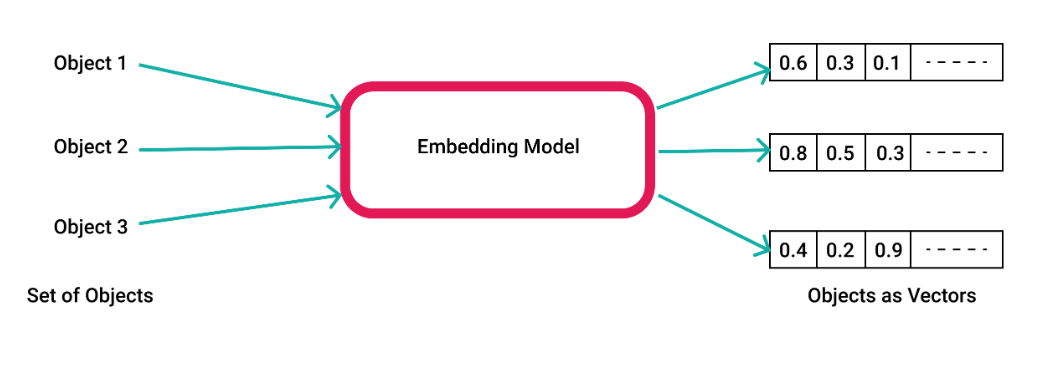

#### In LLMs (Large Language Models), embedding are numerical representations of words, phrases, or sentences that capture their meaning and context. Embeddings are used to represent text in a way that can be processed by machine learning algorithms.<br>There are two main types of embeddings:<br><br>Word embeddings: Word embeddings represent individual words as vectors of numbers. The numbers in a word embedding vector represent the meaning of the word, and the relationships between words.<br><br>Sentence embeddings: Sentence embeddings represent entire sentences as vectors of numbers. Sentence embeddings are created by averaging the word embeddings of the words in the sentence.

In [8]:
# select which embeddings we want to use
embeddings = OpenAIEmbeddings()

#### Creating a vector store

In [9]:
# create the vectorestore to use as the index
db = Chroma.from_documents(document_chunks, embeddings, persist_directory='./database')

In [10]:
# expose this index in a retriever interface
retriever = db.as_retriever(search_type="similarity", search_kwargs={"k":5})

#### Loading the OpenAI model

In [11]:
# Loading the OpenAI model 
llm_model = ChatOpenAI(
    temperature=0,
    openai_api_key=openai.api_key, 
    model="gpt-3.5-turbo")

chain = load_qa_chain(llm_model, chain_type = "stuff")

#### Conversational Retrieval QA chain

In [12]:
# Create a chain to answer questions
qa = ConversationalRetrievalChain.from_llm(llm_model, retriever, chain_type = "stuff")
chat_history = []
query = "what are the penalties for unlawful obtaining, processing or disclosing of data in Rwanda?"

def answer_question(question, chat_history=[]):
    docs = db.similarity_search(query)
    result = qa({"question": question, "chat_history": chat_history})
    return result["answer"]

In [13]:
answer_question(query)

'The penalties for unlawful obtaining, processing, or disclosing of data in Rwanda are as follows:\n\n- Upon conviction, a natural person who unlawfully collects and/or processes sensitive personal data is liable to a fine not less than Five million (5,000,000) Rwandan Francs and not exceeding Ten million (10,000,000) Rwandan Francs, or imprisonment not less than Two (2) years and not exceeding Five (5) years, or both.'

#### Model performance evaluation

In [14]:
from collections import Counter
import re
 

def calculate_ROUGE(generated_summary, reference_summary, n):
    # Tokenize the generated summary and reference summary into n-grams
    generated_ngrams = generate_ngrams(generated_summary, n)
    reference_ngrams = generate_ngrams(reference_summary, n)
 
    # Calculate the recall score
    matching_ngrams = len(set(generated_ngrams) & set(reference_ngrams))
    recall_score = matching_ngrams / len(reference_ngrams)
 
    return recall_score
 

def generate_ngrams(text, n):
    # Preprocess text by removing punctuation and converting to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())
 
    # Generate n-grams from the preprocessed text
    words = text.split()
    ngrams = [tuple(words[i:i+n]) for i in range(len(words) - n + 1)]
 
    return ngrams
 
 
# Example usage
generated_summary = """The penalties for unlawful obtaining, processing, or disclosing of data in Rwanda are as follows:
\n\n- Upon conviction, a natural person who unlawfully collects and/or
processes sensitive personal data is liable to a fine not less than Five million (5,000,000) Rwandan Francs 
and not exceeding Ten million (10,000,000) Rwandan Francs, or imprisonment not less than Two (2) years 
and not exceeding Five (5) years, or both.'"""


reference_summary = """Any natural person who unlawfully obtains, processes, discloses or 
procures the disclosure to another person of data held or processed by a 
data controller or data processor, commits an offence and is liable upon 
conviction to a fine not less than Five million (5,000,000) Rwandan 
Francs and not exceeding Ten million (10,000,000) Rwandan Francs or 
imprisonment not less than Six (6) months and not exceeding Two (2) 
years or both."""
n = 1  # bigram
 
rouge_score = calculate_ROUGE(generated_summary, reference_summary, n)
print(f"ROUGE-{n} score: {rouge_score}")

ROUGE-1 score: 0.4714285714285714


In [15]:
from collections import Counter
import nltk.translate.bleu_score as bleu
 

def calculate_BLEU(generated_summary, reference_summary, n):
    # Tokenize the generated summary and reference summary
    generated_tokens = generated_summary.split()
    reference_tokens = reference_summary.split()
 
    # Calculate the BLEU score
    weights = [1.0 / n] * n  # Weights for n-gram precision calculation
    bleu_score = bleu.sentence_bleu([reference_tokens], generated_tokens, weights=weights)
 
    return bleu_score
 
 
# Example usage
generated_summary = """The penalties for unlawful obtaining, processing, or disclosing of data in Rwanda are as follows:
\n\n- Upon conviction, a natural person who unlawfully collects and/or
processes sensitive personal data is liable to a fine not less than Five million (5,000,000) Rwandan Francs 
and not exceeding Ten million (10,000,000) Rwandan Francs, or imprisonment not less than Two (2) years 
and not exceeding Five (5) years, or both.'"""


reference_summary = """Any natural person who unlawfully obtains, processes, discloses or 
procures the disclosure to another person of data held or processed by a 
data controller or data processor, commits an offence and is liable upon 
conviction to a fine not less than Five million (5.000.000) Rwandan 
Francs and not exceeding Ten million (10.000.000) Rwandan Francs or 
imprisonment not less than Six (6) months and not exceeding Two (2) 
years or both."""

n = 1  # unigram
 
bleu_score = calculate_BLEU(generated_summary, reference_summary, n)
print(f"BLEU-{n} score: {bleu_score}")

BLEU-1 score: 0.5561600555283102


In [16]:
from collections import Counter
import re

def calculate_F1(generated_summary, reference_summary, n):
    # Tokenize the generated summary and reference summary into n-grams
    generated_ngrams = generate_ngrams(generated_summary, n)
    reference_ngrams = generate_ngrams(reference_summary, n)

    # Calculate the recall score
    matching_ngrams = len(set(generated_ngrams) & set(reference_ngrams))
    recall_score = matching_ngrams / len(reference_ngrams)

    # Calculate the precision score
    precision_score = matching_ngrams / len(generated_ngrams)

    # Calculate the F1 score
    f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)

    return f1_score

def generate_ngrams(text, n):
    # Preprocess text by removing punctuation and converting to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())

    # Generate n-grams from the preprocessed text
    words = text.split()
    ngrams = [tuple(words[i:i+n]) for i in range(len(words) - n + 1)]

    return ngrams

# Example usage
generated_summary = """The penalties for unlawful obtaining, processing, or disclosing of data in Rwanda are as follows:
\n\n- Upon conviction, a natural person who unlawfully collects and/or
processes sensitive personal data is liable to a fine not less than Five million (5,000,000) Rwandan Francs 
and not exceeding Ten million (10,000,000) Rwandan Francs, or imprisonment not less than Two (2) years 
and not exceeding Five (5) years, or both.'"""

reference_summary = """Any natural person who unlawfully obtains, processes, discloses or 
procures the disclosure to another person of data held or processed by a 
data controller or data processor, commits an offence and is liable upon 
conviction to a fine not less than Five million (5.000.000) Rwandan 
Francs and not exceeding Ten million (10.000.000) Rwandan Francs or 
imprisonment not less than Six (6) months and not exceeding Two (2) 
years or both."""
n = 1  # unigram

f1_score = calculate_F1(generated_summary, reference_summary, n)
print(f"F1 score: {f1_score}")


F1 score: 0.4888888888888889


In [17]:
from collections import Counter
import re

def calculate_accuracy(generated_summary, reference_summary):
    # Tokenize the generated summary and reference summary
    generated_tokens = generated_summary.split()
    reference_tokens = reference_summary.split()

    # Calculate the accuracy score
    matching_tokens = len(set(generated_tokens) & set(reference_tokens))
    accuracy_score = matching_tokens / len(generated_tokens)

    return accuracy_score

# def generate_ngrams(text, n):
#     # Preprocess text by removing punctuation and converting to lowercase
#     text = re.sub(r'[^\w\s]', '', text.lower())

#     # Generate n-grams from the preprocessed text
#     words = text.split()
#     ngrams = [tuple(words[i:i+n]) for i in range(len(words) - n + 1)]

#     return ngrams

# Example usage
generated_summary = """The penalties for unlawful obtaining, processing, or disclosing of data in Rwanda are as follows:
\n\n- Upon conviction, a natural person who unlawfully collects and/or
processes sensitive personal data is liable to a fine not less than Five million (5,000,000) Rwandan Francs 
and not exceeding Ten million (10,000,000) Rwandan Francs, or imprisonment not less than Two (2) years 
and not exceeding Five (5) years, or both.'"""

reference_summary = """Any natural person who unlawfully obtains, processes, discloses or 
procures the disclosure to another person of data held or processed by a 
data controller or data processor, commits an offence and is liable upon 
conviction to a fine not less than Five million (5,000,000) Rwandan 
Francs and not exceeding Ten million (10,000,000) Rwandan Francs or 
imprisonment not less than Six (6) months and not exceeding Two (2) 
years or both."""

accuracy_score = calculate_accuracy(generated_summary, reference_summary)
print(f"Accuracy score: {accuracy_score}")


Accuracy score: 0.42424242424242425


In [18]:
from collections import Counter
import re
 
def calculate_ROUGE_SU4(generated_summary, reference_summary):
    # Tokenize the generated summary and reference summary into skip-bigrams (unigrams and bigrams with at most one intervening word)
    generated_ngrams = generate_skip_bigrams(generated_summary)
    reference_ngrams = generate_skip_bigrams(reference_summary)
 
    # Calculate the recall score
    matching_ngrams = len(set(generated_ngrams) & set(reference_ngrams))
    recall_score = matching_ngrams / len(reference_ngrams)
 
    return recall_score
 
def generate_skip_bigrams(text):
    # Preprocess text by removing punctuation and converting to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())
 
    # Generate skip-bigrams from the preprocessed text
    words = text.split()
    skip_bigrams = [(words[i], words[j]) for i in range(len(words)) for j in range(i, min(i + 2, len(words)))]
 
    return skip_bigrams
 
# Example usage
generated_summary = """The penalties for unlawful obtaining, processing, or disclosing of data in Rwanda are as follows:
\n\n- Upon conviction, a natural person who unlawfully collects and/or
processes sensitive personal data is liable to a fine not less than Five million (5,000,000) Rwandan Francs 
and not exceeding Ten million (10,000,000) Rwandan Francs, or imprisonment not less than Two (2) years 
and not exceeding Five (5) years, or both.'"""


reference_summary = """Any natural person who unlawfully obtains, processes, discloses or 
procures the disclosure to another person of data held or processed by a 
data controller or data processor, commits an offence and is liable upon 
conviction to a fine not less than Five million (5,000,000) Rwandan 
Francs and not exceeding Ten million (10,000,000) Rwandan Francs or 
imprisonment not less than Six (6) months and not exceeding Two (2) 
years or both."""

rouge_score = calculate_ROUGE_SU4(generated_summary, reference_summary)
print(f"ROUGE-SU4 score: {rouge_score}")


ROUGE-SU4 score: 0.45323741007194246


In [19]:
def calculate_BE(generated_summary, reference_summary):
    # Extract basic elements from generated and reference summaries
    generated_elements = extract_basic_elements(generated_summary)
    reference_elements = extract_basic_elements(reference_summary)

    # Calculate the number of common basic elements
    common_elements = set(generated_elements) & set(reference_elements)

    # Calculate the BE score
    be_score = len(common_elements) / max(len(reference_elements), 1)

    return be_score

def extract_basic_elements(text):
    # Hypothetical function for extracting basic elements
    # You would need to implement this based on your specific requirements
    # For demonstration purposes, it just splits the text into words
    return text.split()

# Example usage
generated_summary = """The penalties for unlawful obtaining, processing, or disclosing of data in Rwanda are as follows:
\n\n- Upon conviction, a natural person who unlawfully collects and/or
processes sensitive personal data is liable to a fine not less than Five million (5,000,000) Rwandan Francs 
and not exceeding Ten million (10,000,000) Rwandan Francs, or imprisonment not less than Two (2) years 
and not exceeding Five (5) years, or both."""

reference_summary = """Any natural person who unlawfully obtains, processes, discloses or 
procures the disclosure to another person of data held or processed by a 
data controller or data processor, commits an offence and is liable upon 
conviction to a fine not less than Five million (5,000,000) Rwandan 
Francs and not exceeding Ten million (10,000,000) Rwandan Francs or 
imprisonment not less than Six (6) months and not exceeding Two (2) 
years or both."""

be_score = calculate_BE(generated_summary, reference_summary)
print(f"BE score: {be_score}")


BE score: 0.4142857142857143
